In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
patients = pd.read_csv('../data/raw/patients.csv')
encounters = pd.read_csv('../data/raw/encounters.csv')
conditions = pd.read_csv('../data/raw/conditions.csv')

In [3]:
# Data Exploration
print("Patients Tables:", patients.columns.tolist())
print("Encounters Tables:", encounters.columns.tolist())
print("Patients Samples:", patients.head(3))

Patients Tables: ['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE']
Encounters Tables: ['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER', 'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST', 'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION']
Patients Samples:                                      Id   BIRTHDATE DEATHDATE          SSN  \
0  b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85  2019-02-17       NaN  999-65-3251   
1  c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8  2005-07-04       NaN  999-49-3323   
2  339144f8-50e1-633e-a013-f361391c4cff  1998-05-11       NaN  999-10-8743   

     DRIVERS    PASSPORT PREFIX     FIRST            LAST SUFFIX  ...  \
0        NaN         NaN    NaN  Damon455      Langosh790    NaN  ...   
1  S999

In [4]:
# Encounter Type Distribution
print("Encounter Type Distribution:")
print(encounters['ENCOUNTERCLASS'].value_counts())

Encounter Type Distribution:
ENCOUNTERCLASS
wellness      24038
ambulatory    20124
outpatient    10837
urgentcare     2564
emergency      2168
inpatient      1728
Name: count, dtype: int64


In [5]:
# Filtering inpatient data
inpatient_encounters = encounters[encounters.ENCOUNTERCLASS == 'inpatient'].copy()
print(f"Total Inpatient Encounters: {len(inpatient_encounters)}")

Total Inpatient Encounters: 1728


In [6]:
# Fixing date formats
inpatient_encounters['START'] = pd.to_datetime(inpatient_encounters['START'])
inpatient_encounters['STOP'] = pd.to_datetime(inpatient_encounters['STOP'])

In [7]:
# Calculating of LOS
inpatient_encounters['length_of_stay'] = (inpatient_encounters['STOP'] - inpatient_encounters['START']).dt.days

In [8]:
print("Length of Stay (LOS) Statistics:")
print(inpatient_encounters['length_of_stay'].describe())

Length of Stay (LOS) Statistics:
count    1728.000000
mean        4.447338
std       119.913570
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      4969.000000
Name: length_of_stay, dtype: float64


In [9]:
# Analyzing long stays
long_stays = inpatient_encounters[inpatient_encounters['length_of_stay'] > 30]
print(f"Number of stays longer than 30 days: {len(long_stays)}")
print("First 5 long stays:")
print(long_stays[['START', 'STOP', 'length_of_stay']].head())

Number of stays longer than 30 days: 4
First 5 long stays:
                          START                      STOP  length_of_stay
1294  2013-03-30 06:57:17+00:00 2013-05-26 06:57:17+00:00              57
16013 2013-05-21 19:55:48+00:00 2014-04-21 17:11:36+00:00             334
19374 1997-11-25 15:07:05+00:00 1998-07-19 15:07:05+00:00             236
36821 1996-07-28 02:24:36+00:00 2010-03-06 02:24:36+00:00            4969


In [10]:
# Filtering normal stays
normal_stays = inpatient_encounters[inpatient_encounters['length_of_stay'] <= 30]
print(f"Number of stays shorter than or equal to 30 days: {len(normal_stays)}")
print("Statistics of normal stays:")
print(normal_stays['length_of_stay'].describe())

Number of stays shorter than or equal to 30 days: 1724
Statistics of normal stays:
count    1724.000000
mean        1.211717
std         1.357194
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        30.000000
Name: length_of_stay, dtype: float64


In [11]:
# Data suitable for readmission analysis
readmission_data = inpatient_encounters[inpatient_encounters['length_of_stay'] <= 30].copy()
print(f"Number of patients suitable for readmission analysis: {len(readmission_data)}")
print(f"Number of long stays excluded (>30 days): {len(inpatient_encounters) - len(readmission_data)}")

Number of patients suitable for readmission analysis: 1724
Number of long stays excluded (>30 days): 4


In [12]:
# Length of stay categorization
stay_bins = [0, 1, 3, 7, 14, 30]
stay_labels = ['1 day', '1-3 days', '3-7 days', '1-2 weeks', '2-4 weeks']
readmission_data['stay_category'] = pd.cut(readmission_data['length_of_stay'], 
                                           bins=stay_bins, labels=stay_labels)

print("Distribution of stays (for readmission analysis):")
print(readmission_data['stay_category'].value_counts().sort_index())

Distribution of stays (for readmission analysis):
stay_category
1 day        1637
1-3 days       47
3-7 days       17
1-2 weeks      21
2-4 weeks       2
Name: count, dtype: int64


Length of stay statistics (0-30 days):
count    1724.000000
mean        1.211717
std         1.357194
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        30.000000
Name: length_of_stay, dtype: float64


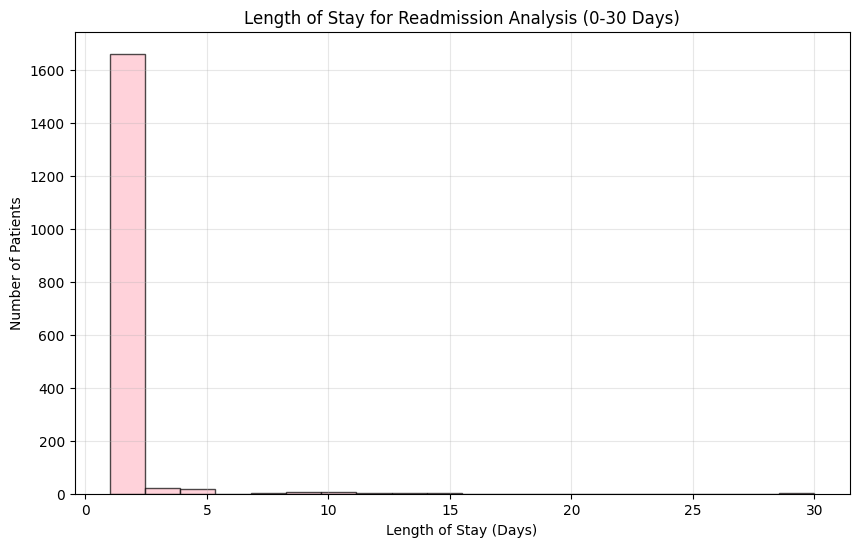

In [13]:
# Descriptive statistics
print("Length of stay statistics (0-30 days):")
print(readmission_data['length_of_stay'].describe())

# Visualization 
plt.figure(figsize=(10, 6))
plt.hist(readmission_data['length_of_stay'], bins=20, color='pink', edgecolor='black', alpha=0.7)
plt.title('Length of Stay for Readmission Analysis (0-30 Days)')
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Number of Patients')
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# Advanced readmission calculation

# Sorting the data 
readmission_data = readmission_data.sort_values(['PATIENT', 'START']).copy()

# Data Quality Checks
print("Data Quality Checks:")
print(f"Encounters with STOP date before START: {len(readmission_data[readmission_data['STOP'] < readmission_data['START']])}")
print(f"Missing START dates: {readmission_data['START'].isnull().sum()}")
print(f"Missing STOP dates: {readmission_data['STOP'].isnull().sum()}")

Data Quality Checks:
Encounters with STOP date before START: 0
Missing START dates: 0
Missing STOP dates: 0


In [15]:
# Checking same-day transfers
readmission_data['admission_date'] = readmission_data['START'].dt.date
readmission_data['discharge_date'] = readmission_data['STOP'].dt.date

# Filtering patients with multiple admissions
patient_admission_counts = readmission_data['PATIENT'].value_counts()
patients_with_multiple_admissions = patient_admission_counts[patient_admission_counts > 1].index

print(f"Patients with only one admission: {len(patient_admission_counts[patient_admission_counts == 1])}")
print(f"Patients with multiple admissions: {len(patients_with_multiple_admissions)}")

Patients with only one admission: 177
Patients with multiple admissions: 108


In [16]:
readmission_analysis_data = readmission_data[readmission_data['PATIENT'].isin(patients_with_multiple_admissions)].copy()

In [17]:
# Calculating next admission date
readmission_analysis_data['next_admission_date'] = readmission_analysis_data.groupby('PATIENT')['START'].shift(-1)
readmission_analysis_data['next_admission_patient'] = readmission_analysis_data.groupby('PATIENT')['PATIENT'].shift(-1)

In [18]:
# Filtering records with only valid next admissions
eligible_discharges = readmission_analysis_data[readmission_analysis_data['next_admission_date'].notna()].copy()

In [19]:
# Calculate readmission duration
eligible_discharges['days_to_readmit'] = (eligible_discharges['next_admission_date'] - eligible_discharges['STOP']).dt.days

In [20]:
# Exclude same-day transfers (not true readmissions)
eligible_discharges['same_day_transfer'] = eligible_discharges['days_to_readmit'] == 0

In [21]:
# Readmission flags
eligible_discharges['readmission_30_days'] = (
    (eligible_discharges['days_to_readmit'] <= 30) & 
    (eligible_discharges['days_to_readmit'] > 0)  # Aynı gün transferleri hariç tut
)

eligible_discharges['readmission_90_days'] = (
    (eligible_discharges['days_to_readmit'] <= 90) & 
    (eligible_discharges['days_to_readmit'] > 0)
)

In [22]:
# Calculating redmission rates
total_eligible_discharges = len(eligible_discharges)
readmissions_30 = eligible_discharges['readmission_30_days'].sum()
readmissions_90 = eligible_discharges['readmission_90_days'].sum()
same_day_transfers = eligible_discharges['same_day_transfer'].sum()

readmission_rate_30 = (readmissions_30 / total_eligible_discharges) * 100 if total_eligible_discharges > 0 else 0
readmission_rate_90 = (readmissions_90 / total_eligible_discharges) * 100 if total_eligible_discharges > 0 else 0

print(f"\nReadmission Statistics (Improved Calculation):")
print(f"Total eligible discharges (with subsequent admissions): {total_eligible_discharges}")
print(f"Same-day transfers (excluded from readmissions): {same_day_transfers}")
print(f"Readmissions within 30 days: {readmissions_30}")
print(f"Readmissions within 90 days: {readmissions_90}")
print(f"30-day readmission rate: {readmission_rate_30:.2f}%")
print(f"90-day readmission rate: {readmission_rate_90:.2f}%")


Readmission Statistics (Improved Calculation):
Total eligible discharges (with subsequent admissions): 1439
Same-day transfers (excluded from readmissions): 138
Readmissions within 30 days: 396
Readmissions within 90 days: 799
30-day readmission rate: 27.52%
90-day readmission rate: 55.52%


In [23]:
# Readmission analysis by LOS category
if total_eligible_discharges > 0:
    readmission_by_category = eligible_discharges.groupby('stay_category').agg({
        'readmission_30_days': ['count', 'sum', 'mean'],
        'days_to_readmit': 'mean'
    }).round(3)
    
    readmission_by_category.columns = ['total_discharges', 'readmissions', 'readmission_rate', 'avg_days_to_readmit']
    readmission_by_category['readmission_rate_pct'] = (readmission_by_category['readmission_rate'] * 100).round(2)
    
    print("\nReadmission rates by LOS category:")
    print(readmission_by_category[['total_discharges', 'readmissions', 'readmission_rate_pct', 'avg_days_to_readmit']])


Readmission rates by LOS category:
               total_discharges  readmissions  readmission_rate_pct  \
stay_category                                                         
1 day                      1408           395                  28.1   
1-3 days                     21             1                   4.8   
3-7 days                      7             0                   0.0   
1-2 weeks                     2             0                   0.0   
2-4 weeks                     1             0                   0.0   

               avg_days_to_readmit  
stay_category                       
1 day                      410.347  
1-3 days                  3354.524  
3-7 days                  7336.857  
1-2 weeks                    0.000  
2-4 weeks                   -2.000  


C:\Users\DELL\AppData\Local\Temp\ipykernel_11320\1165792924.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readmission_by_category = eligible_discharges.groupby('stay_category').agg({


In [24]:
# Annual trend analysis
eligible_discharges['admission_year'] = eligible_discharges['START'].dt.year
yearly_trend = eligible_discharges.groupby('admission_year').agg({
    'readmission_30_days': ['count', 'sum', 'mean'],
    'days_to_readmit': 'mean'
}).round(3)

if not yearly_trend.empty:
    yearly_trend.columns = ['total_discharges', 'readmissions', 'readmission_rate', 'avg_days_to_readmit']
    yearly_trend['readmission_rate_pct'] = (yearly_trend['readmission_rate'] * 100).round(2)
    
    print("\nYearly readmission trends:")
    print(yearly_trend[['total_discharges', 'readmissions', 'readmission_rate_pct', 'avg_days_to_readmit']])


Yearly readmission trends:
                total_discharges  readmissions  readmission_rate_pct  \
admission_year                                                         
1928                           1             0                   0.0   
1931                           1             0                   0.0   
1950                           1             0                   0.0   
1951                           1             0                   0.0   
1952                           2             0                   0.0   
1953                           1             0                   0.0   
1959                           1             0                   0.0   
1966                           1             0                   0.0   
1968                           2             0                   0.0   
1970                           1             0                   0.0   
1971                           3             0                   0.0   
1972                           2    

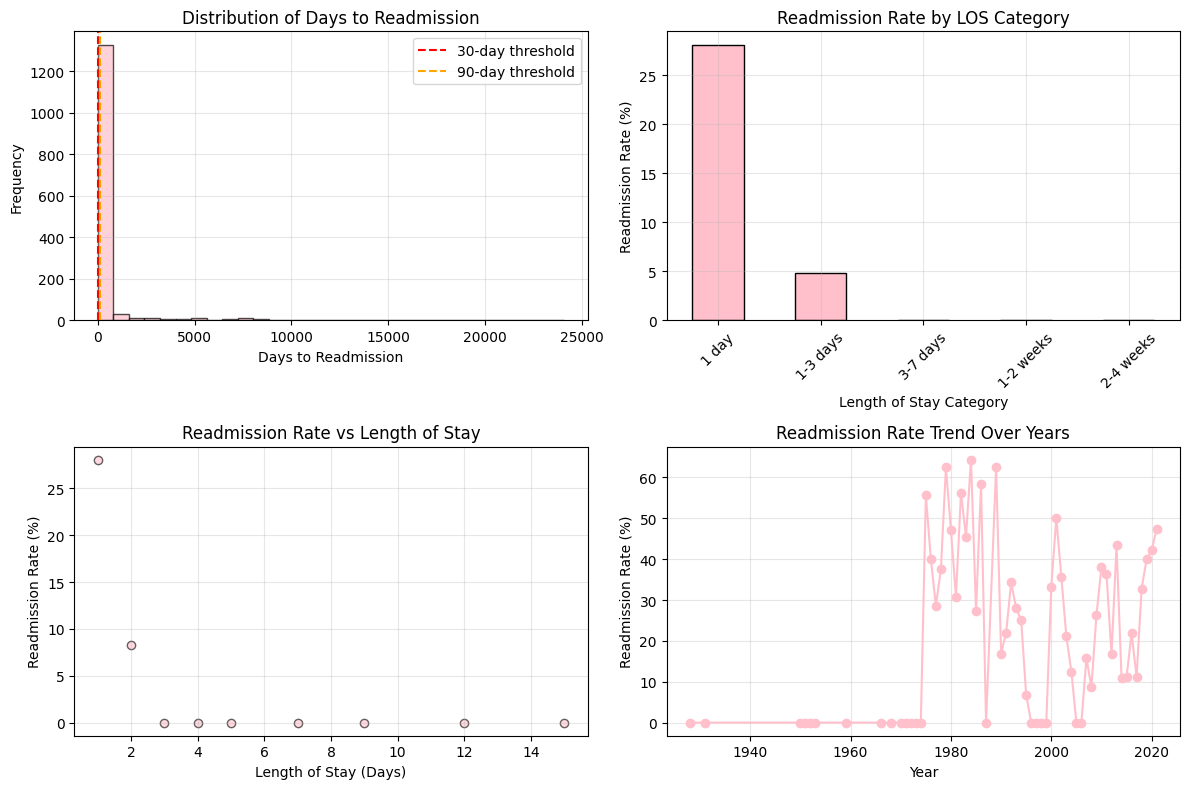

In [25]:
# Distribution of readmission durations
plt.figure(figsize=(12, 8))

# Histogram of days to readmission
plt.subplot(2, 2, 1)
plt.hist(eligible_discharges['days_to_readmit'].dropna(), bins=30, color='pink', edgecolor='black', alpha=0.7)
plt.axvline(x=30, color='red', linestyle='--', label='30-day threshold')
plt.axvline(x=90, color='orange', linestyle='--', label='90-day threshold')
plt.title('Distribution of Days to Readmission')
plt.xlabel('Days to Readmission')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Readmission rate by LOS category
plt.subplot(2, 2, 2)
readmission_by_category['readmission_rate_pct'].plot(kind='bar', color='pink', edgecolor='black')
plt.title('Readmission Rate by LOS Category')
plt.xlabel('Length of Stay Category')
plt.ylabel('Readmission Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Scatter plot: Readmission rate vs LOS
plt.subplot(2, 2, 3)
readmission_30_by_los = eligible_discharges.groupby('length_of_stay')['readmission_30_days'].mean() * 100
plt.scatter(readmission_30_by_los.index, readmission_30_by_los.values, color='pink', edgecolor='black', alpha=0.6)
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Readmission Rate (%)')
plt.title('Readmission Rate vs Length of Stay')
plt.grid(True, alpha=0.3)

# Yearly trend
plt.subplot(2, 2, 4)
if not yearly_trend.empty:
    yearly_trend['readmission_rate_pct'].plot(marker='o', color='pink')
    plt.title('Readmission Rate Trend Over Years')
    plt.xlabel('Year')
    plt.ylabel('Readmission Rate (%)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
print("\nDetailed Readmission Analysis:")
print(f"Median days to readmission: {eligible_discharges['days_to_readmit'].median():.1f} days")
print(f"Mean days to readmission: {eligible_discharges['days_to_readmit'].mean():.1f} days")
print(f"Readmissions within 7 days: {(eligible_discharges['days_to_readmit'] <= 7).sum()}")
print(f"Readmissions within 14 days: {(eligible_discharges['days_to_readmit'] <= 14).sum()}")


Detailed Readmission Analysis:
Median days to readmission: 31.0 days
Mean days to readmission: 486.2 days
Readmissions within 7 days: 263
Readmissions within 14 days: 273


In [27]:
# Readmission time distribution
readmission_time_bins = [0, 7, 14, 30, 90, 365, float('inf')]
readmission_time_labels = ['0-7 days', '8-14 days', '15-30 days', '31-90 days', '91-365 days', '>365 days']
readmission_times = pd.cut(eligible_discharges['days_to_readmit'], 
                          bins=readmission_time_bins, labels=readmission_time_labels)

print("\nReadmission time distribution:")
print(readmission_times.value_counts().sort_index())


Readmission time distribution:
days_to_readmit
0-7 days        11
8-14 days       10
15-30 days     375
31-90 days     403
91-365 days    202
>365 days      186
Name: count, dtype: int64
